<a href="https://colab.research.google.com/github/pdkary/VincentGANVogh/blob/main/Vinny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/pdkary/VincentGANVogh.git
!cd VincentGANVogh/ && git fetch
!cd VincentGANVogh/ && git pull
!pip install -r /content/VincentGANVogh/requirements.txt
 
import sys
sys.path.insert(0,'/content/VincentGANVogh')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
style_input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
noise_image_input (InputLayer)  [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
latent_space_input (InputLayer) [(None, 4, 4, 512)]  0                                            
__________________________________________________________________________________________________
generator_base (Functional)     (None, 256, 256, 3)  2

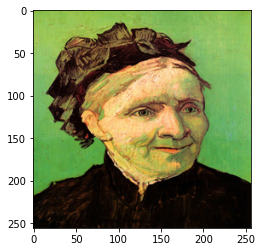

In [ ]:
from GanConfig import GanShapeConfig,GanBuildingConfig,GanTrainingConfig
from GanTrainer import GanTrainer
from keras.optimizers import Adam
 
from google.colab import drive
drive.mount('/content/drive')
 
gan_shape_config = GanShapeConfig(
    img_shape=(256,256,3),
    gen_constant_shape=(4,4,512),
    style_size=100,
    kernel_size=3,
    noise_kernel_size=3,
    style_layer_size=512,
    style_layers=3,
    gen_layer_shapes=[(512,2),(512,2),(256,2),(128,2),(64,2),(64,2),(64,2),(32,2),(32,2)],
    gen_layer_upsampling=[False,True,True,True,True,False,True,True,False],
    gen_layer_noise=[True,True,True,True,True,True,True,True,True],
    disc_layer_shapes=[(32,3),(32,2),(64,2),(128,2),(256,3),(512,3)],
    disc_dense_sizes=[4096,4096,1024],
    minibatch=True,
    minibatch_size=16
)
 
gan_building_config = GanBuildingConfig(
    relu_alpha=0.08,
    dropout_rate=0.6,
    batch_norm_momentum=0.8
)
 
gan_training_config = GanTrainingConfig(
    gen_optimizer = Adam(2e-4,beta_1=0.75),
    disc_optimizer = Adam(2e-4,beta_1=0.75),
    disc_loss_function="binary_crossentropy",
    gen_loss_function="binary_crossentropy",
    use_latent_noise=False,
    gauss_factor=1,
    batch_size=16,
    preview_rows=3,
    preview_cols=4,
    data_path='/content/drive/MyDrive/Colab/VanGogh',
    image_type=".jpg",
    model_name='/GANVogh_generator_model_',
    flip_lr=True,
    load_n_percent=100
)
 
VGV = GanTrainer(gan_shape_config,gan_building_config,gan_training_config)

In [ ]:
#TRAINING
ERAS = 100
EPOCHS = 2000
BATCHES_PER_EPOCH = 1
PRINT_EVERY = 10
MOVING_AVERAGE_SIZE = 20
 
VGV.train_n_eras(ERAS,EPOCHS,BATCHES_PER_EPOCH,PRINT_EVERY,MOVING_AVERAGE_SIZE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>